
## How to Use the Notebooks

To run these notebooks, follow these steps:


### 1. Install **`gdal`** Package
Installing `gdal` via `pip` may fail. Therefore, we recommend using conda to install it:
```bash
conda install gdal -c conda-forge
```

### 2. Install **`polsartools`** Package

Before running the notebooks, you'll need to install the core **`polsartools`** package. 

**Option A:** Install from PyPI `pip` (stable release)

```bash
pip install polsartools
```

**Option B:** Install from conda (stable release)

```bash
conda install polsartools -c bnarayanarao
```


**Option C:**  Install the latest version from GitHub (if you need recent updates or fixes)

```bash
pip install git+https://github.com/Narayana-Rao/polsartools.git#egg=polsartools
```
> **Note:** If you encounter a `"module not found"` error or require newer features, prefer the **Option C**.

### 3. Verify the Installation

After successfully installing `polsartools`, you can verify it by importing the package:

```bash
import polsartools as pst
```

If this runs without errors, you're ready to explore and run the notebooks.




In [1]:
import polsartools as pst
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np


In [2]:
""" 

Function to display images

"""

def plot_images(*filenames, lower_percentile=2, upper_percentile=98, max_cols=4):
    def compute_vmin_vmax(data):
        data_no_nan = data[np.isfinite(data)]
        vmin = np.percentile(data_no_nan, lower_percentile)
        vmax = np.percentile(data_no_nan, upper_percentile)
        return vmin, vmax

    num_images = len(filenames)

    if num_images == 1:
        # Single image case
        data = pst.read_rst(filenames[0])
        data[data==0]=np.nan
        vmin, vmax = compute_vmin_vmax(data)

        fig, ax = plt.subplots(figsize=(6, 6))
        im = ax.imshow(data, vmin=vmin, vmax=vmax)
        ax.set_title(os.path.basename(filenames[0]))
        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()
    else:
        # Multiple image case
        ncols = min(max_cols, num_images)
        nrows = int(np.ceil(num_images / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
        axes = np.array(axes).reshape(-1)  # Flatten in case it's a 2D grid

        for i, filename in enumerate(filenames):
            data = pst.read_rst(filename)
            data[data==0]=np.nan
            vmin, vmax = compute_vmin_vmax(data)
            ax = axes[i]
            im = ax.imshow(data, vmin=vmin, vmax=vmax)
            ax.set_title(os.path.basename(filename))
            fig.colorbar(im, ax=ax)

        for j in range(num_images, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()


#### 1. Extract single look S2 or multilooked T3/C3 matrix elements
ASAR data can be downloaded from [https://uavsar.jpl.nasa.gov/cgi-bin/asar-data.pl](https://uavsar.jpl.nasa.gov/cgi-bin/asar-data.pl)

The sample a dataset used in this tutorial can be downloaded from the following URLs

http://downloaduav.jpl.nasa.gov/Release2s/Rosamd_1702N_A2102_003_210630/V1.3.B/L/ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B.h5

http://downloaduav.jpl.nasa.gov/Release2s/Rosamd_1702N_A2102_003_210630/V1.3.B/S/ASAR_S_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B.h5

In [4]:
# Provide path to the extracted folder

inFile = r"ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B.h5"

#The follwoing function extracts single look S2 or mulit-looked T3/C3 matrix from ISRO's ASAR Full Pol data
pst.isro_asar(inFile,matrixType='C3',azlks=22,rglks=10) # for a multi-look factor of 2.16


Detected L-band ['VV' 'VH' 'HV' 'HH'] 
Extracting C3 matrix elements...


Processing chunks: 100%|█████████████████████████████████████████████████████████████| 490/490 [02:19<00:00,  3.50it/s]


Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C11.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C12_real.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C12_imag.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C13_real.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C13_imag.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C22.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C23_real.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C23_imag.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C33.tif
Execution time for isro_asar: 05:45 (min:sec)


#### 2. Speckle filtering using polarimetric refined-Lee filter

In [5]:
"""
The following function generates speckle filtered polarimetric matrices using the refined Lee polarimetric speckle filter: 
        
input C3/T3/C2/T2 folder path, window_size

"""

C3Folder = os.path.join(inFile.split('.h5')[0],'C3')
window_size = 3
pst.rlee(C3Folder,window_size=window_size)

Progress: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.93s/block]


Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C11.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C12_real.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C12_imag.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C13_real.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C13_imag.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C22.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C23_real.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C23_imag.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C33.tif
Execution time for rlee: 35.00 seconds


#### 3. Generate a quick look Pauli RGB from C3/T3 matrix

Pauli RGB image saved as .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\PauliRGB.png
Execution time for pauliRGB: 2.00 seconds


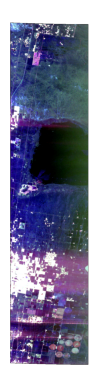

In [6]:
# update the C3 folder based on your folder
C3Folder = r'.\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3'

pst.pauliRGB(C3Folder)

#### 4. Generating Decomposition parameters

#### 4.1. Generate H/A/α Decomposition parameters

Progress: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.73s/block]


Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\H_fp.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\alpha_fp.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\anisotropy_fp.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\e1_norm.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\e2_norm.tif
Saved file .\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\e3_norm.tif
Execution time for halphafp: 50.00 seconds


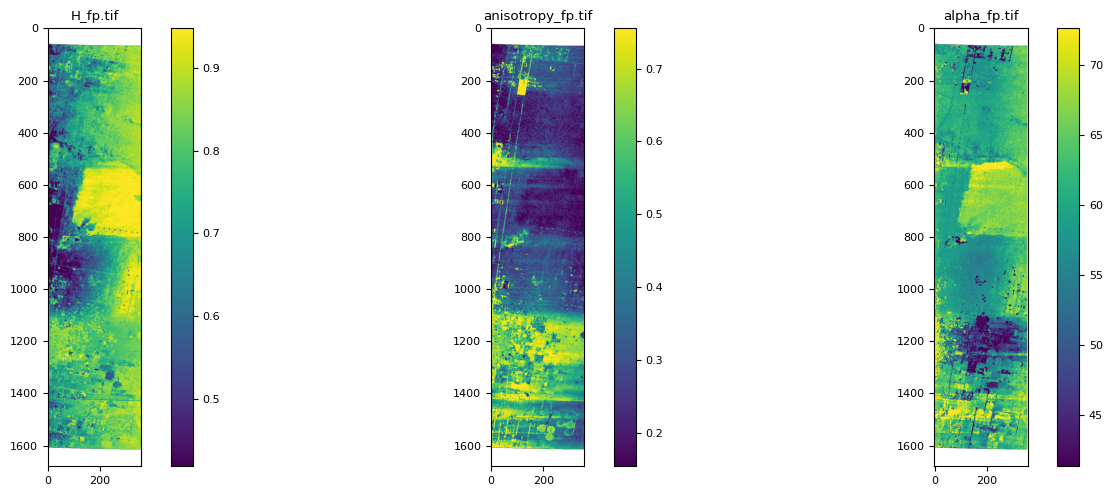

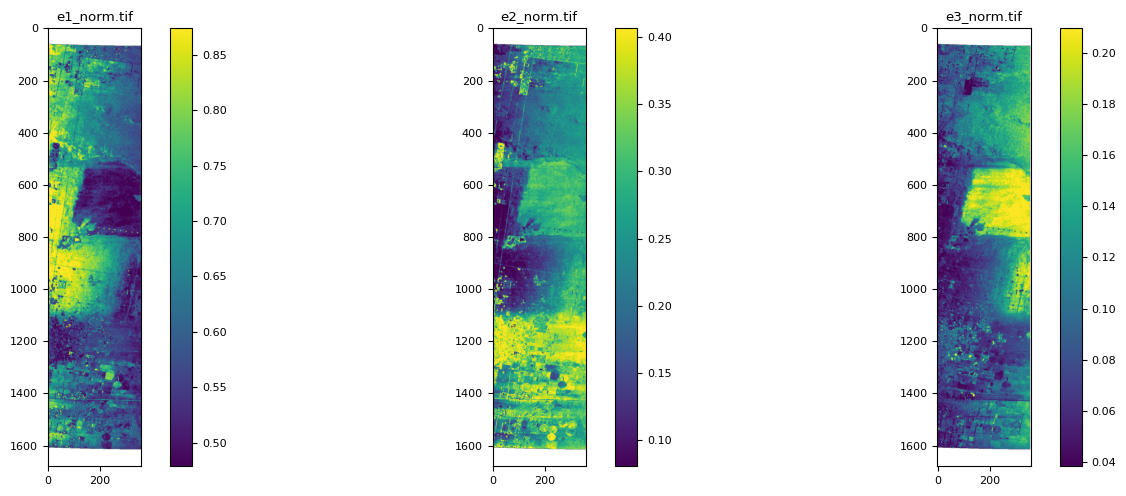

In [7]:

"""
The following function generates H/A/alpha demposition paramters: 
        Alpha, entropy, anisotropy and 
        normalized eigen values e1_norm, e2_norm, e3_norm in geotif format

input C3/T3 folder path, window_size is optional  

"""
# update the C3 folder based on your folder
# C3Folder = '._rlee_3x3\C3'

pst.halphafp(C3Folder,window_size=3) 


### Plotting
plot_images(os.path.join(C3Folder,'H_fp.tif'),
             os.path.join(C3Folder,'anisotropy_fp.tif'),
              os.path.join(C3Folder,'alpha_fp.tif'))

plot_images(os.path.join(C3Folder,'e1_norm.tif'),
             os.path.join(C3Folder,'e2_norm.tif'),
             os.path.join(C3Folder,'e3_norm.tif'))




#### Plot Entropy-Alpha 2D plane

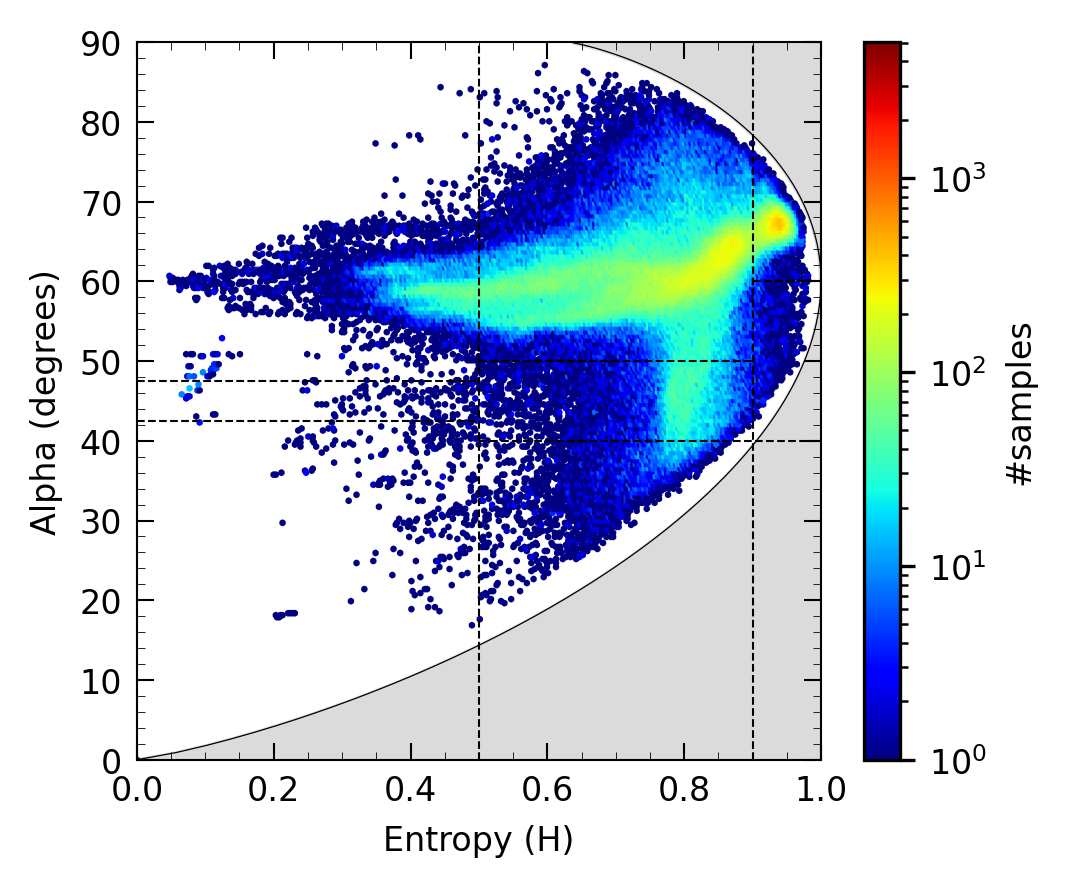

In [8]:
hFile = C3Folder + '/H_fp.tif'
alphaFile = C3Folder + '/alpha_fp.tif'

pst.halpha_plot_fp(hFile,alphaFile,cmap='jet',               
                   norm='log',
                   # path = '',# give a name.png to save the plot as png 
                  zone_lines=True,
                  zone_ids=False,)